In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import os

data_raw = pd.read_csv('survey.csv')
data_raw.tail()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
1254,2015-09-12 11:17:21,26,male,United Kingdom,NaN,No,No,Yes,NaN,26-100,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
1255,2015-09-26 01:07:35,32,Male,United States,IL,No,Yes,Yes,Often,26-100,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,NaN
1256,2015-11-07 12:36:58,34,male,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,NaN
1257,2015-11-30 21:25:06,46,f,United States,NC,No,No,No,NaN,100-500,...,Don't know,Yes,No,No,No,No,No,No,No,NaN
1258,2016-02-01 23:04:31,25,Male,United States,IL,No,Yes,Yes,Sometimes,26-100,...,Don't know,Maybe,No,Some of them,No,No,No,Don't know,No,NaN


In [2]:
# representative data sample

data_raw.head(5).T

,0,1,2,3,4
Timestamp,2014-08-27 11:29:31,2014-08-27 11:29:37,2014-08-27 11:29:44,2014-08-27 11:29:46,2014-08-27 11:30:22
Age,37,44,32,31,31
Gender,Female,M,Male,Male,Male
Country,United States,United States,Canada,United Kingdom,United States
state,IL,IN,NaN,NaN,TX
self_employed,NaN,NaN,NaN,NaN,NaN
family_history,No,No,No,Yes,No
treatment,Yes,No,No,Yes,No
work_interfere,Often,Rarely,Rarely,Often,Never
no_employees,6-25,More than 1000,6-25,26-100,100-500


## Unique anwers values

In [3]:
unique_values = {col: data_raw[col].unique() for col in data_raw.columns}
print("\nUnique values for each of the {} features: ".format(len(data_raw.columns)))
for index, (col, values) in enumerate(unique_values.items()):
    if index < len(data_raw.columns):
        print(f"{index+1}: {col}: {values}")


Unique values for each of the 27 features: 
1: Timestamp: ['2014-08-27 11:29:31' '2014-08-27 11:29:37' '2014-08-27 11:29:44' ...
 '2015-11-07 12:36:58' '2015-11-30 21:25:06' '2016-02-01 23:04:31']
2: Age: [         37          44          32          31          33          35
          39          42          23          29          36          27
          46          41          34          30          40          38
          50          24          18          28          26          22
          19          25          45          21         -29          43
          56          60          54         329          55 99999999999
          48          20          57          58          47          62
          51          65          49       -1726           5          53
          61           8          11          -1          72]
3: Gender: ['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' '

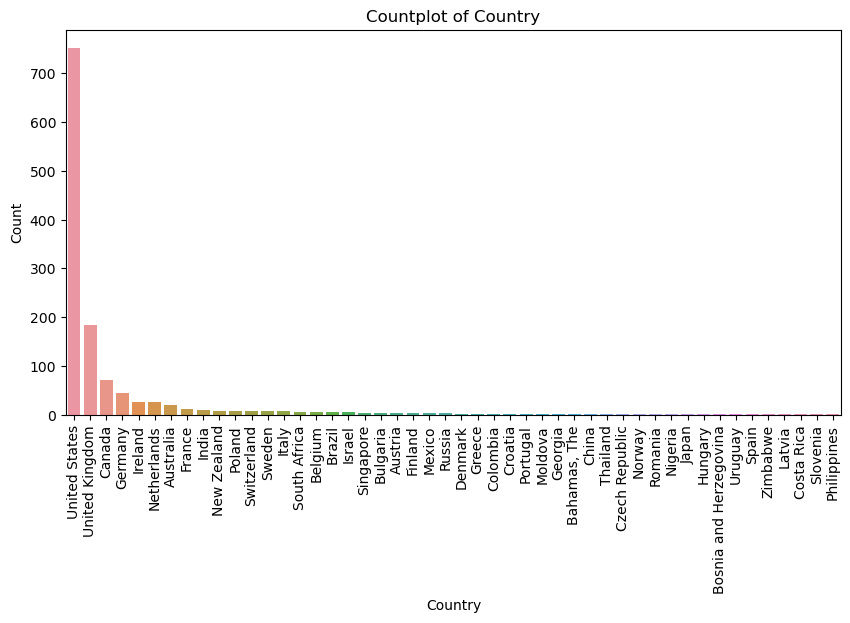

In [4]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Country', data=data_raw, order=data_raw['Country'].value_counts().index)
plt.title('Countplot of Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.savefig('country-countplot.png')
plt.show()

## Data cleaning
1. Column names -> lower case
2. Age - invalid data
2. Gender - too many options -> narrow down to {Female, Male, Others}
3. Filter timestamp to 2014 only
4. Dropping unnecessary colums: timestamp, country, state, comments

In [5]:
data = data_raw
data.columns = data.columns.str.lower()

In [6]:
# filter age
data = data[(data['age'] >= 18) & (data['age'] <= 70)]

print(f'\nCurrent number of entries: {len(data)}')


Current number of entries: 1250


In [7]:
# clean gender values

def simplify_gender(gender):
    if gender in ['Female', 'female', 'F', 'f', 'Woman', 'woman']:
        return 'female'
    elif gender in ['Male', 'male', 'M', 'm', 'Man']:
        return 'male'
    else:
        return 'other'

data['gender'] = data[['gender']].applymap(simplify_gender) 
print(data['gender'].value_counts())

male      968
female    239
other      43
Name: gender, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_15648\2870030317.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gender'] = data[['gender']].applymap(simplify_gender)


In [8]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data[data['timestamp'].dt.year == 2014]
print(f'\nCurrent number of entries: {len(data)}')


Current number of entries: 1181


C:\Users\User\AppData\Local\Temp\ipykernel_15648\4192416627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp'] = pd.to_datetime(data['timestamp'])


In [9]:
# drop unnecesary colums
data = data.drop(['timestamp', 'country', 'state', 'comments'], axis=1)
data.head()

,age,gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,female,NaN,No,Yes,Often,6-25,No,Yes,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,male,NaN,No,No,Rarely,More than 1000,No,No,Don't know,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,male,NaN,No,No,Rarely,6-25,No,Yes,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,male,NaN,Yes,Yes,Often,26-100,No,Yes,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,male,NaN,No,No,Never,100-500,Yes,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


## Dealing with missing data

In [10]:
print("Number of missing values: ")
print(data.isnull().sum())

Number of missing values: 
age                            0
gender                         0
self_employed                 18
family_history                 0
treatment                      0
work_interfere               250
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
dtype: int64


'work_interefere': nan -> 'Unknown'

'self_employed: drop nan

In [11]:
data['work_interfere'].fillna('Unknown', inplace=True)
data.dropna(subset=['self_employed'], inplace=True)
print(data.isnull().sum())

age                          0
gender                       0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
dtype: int64


In [12]:
profile = ProfileReport(data, title="Profiling Report")
# profile.to_widgets()

In [13]:
no_entries = len(data)
no_colums = len(data.columns)
print(f'Number of entries: {no_entries}')
print(f'Number of columns: {no_colums}')

Number of entries: 1163
Number of columns: 23


## Basic statistics

In [14]:
def get_basic_stats(col_names, data, file_name):
    max_i = len(col_names) // 2
    fig, axes = plt.subplots(max_i, 2, figsize=(8, max_i * 4))
    for i in range(max_i):
        for j in range(2):
            if len(col_names) > i * 2 + j:
                sns.countplot(x=col_names[i * 2 + j], data=data, ax=axes[i, j])
                axes[i, j].set_title(col_names[i * 2 + j])
                axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=45)

    plt.tight_layout(pad=2)
    plt.xticks(fontsize=12)
    plt.savefig(os.path.join('images', file_name))
    plt.show()


## Personal info statistics

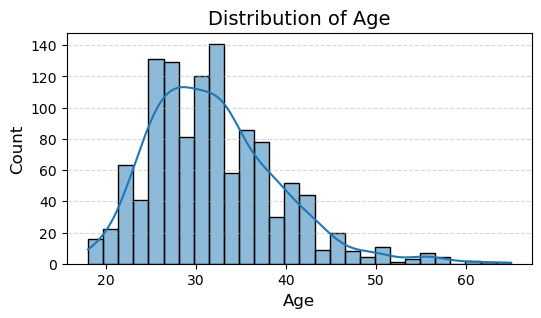

Average age: 32.03


In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(data=data, x='age', edgecolor='black', kde=True)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Age', fontsize=14)
ax.tick_params(axis='both', labelsize=10)
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.savefig(os.path.join('images', 'age-distribution.png'))
plt.show()

avg_age = round(np.average(data['age']), 2)
print(f'Average age: {avg_age}')


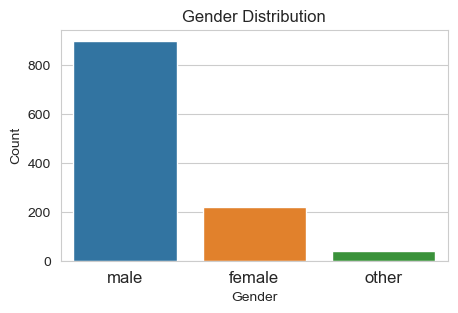

In [16]:
plt.figure(figsize=(5, 3))
gender_counts = data['gender'].value_counts()
sns.set_style("whitegrid")
sns.barplot(x=gender_counts.index, y=gender_counts.values, )
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(fontsize=12)
plt.savefig(os.path.join('images', 'gender-distribution.png'))
plt.show()

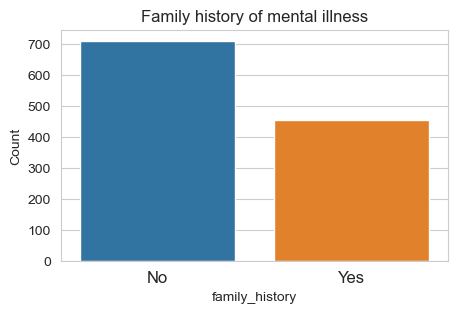

<Figure size 640x480 with 0 Axes>

In [17]:
plt.figure(figsize=(5, 3))
family_history_counts = data['family_history'].value_counts()
sns.set_style("whitegrid")
sns.barplot(x=family_history_counts.index, y=family_history_counts.values)
plt.title("Family history of mental illness")
plt.xlabel("family_history")
plt.ylabel("Count")
plt.xticks(fontsize=12)
plt.show()
plt.savefig(os.path.join('images', 'familyhistory-countplot.png'))

Mental health - basic statistics

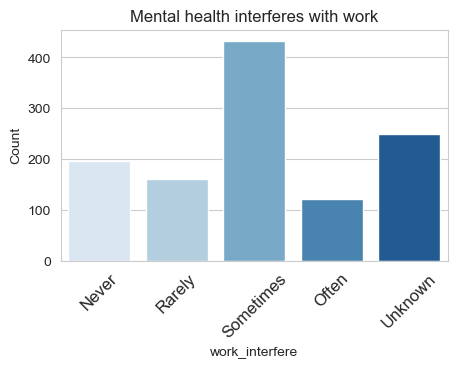

In [18]:
plt.figure(figsize=(5, 3))
sns.countplot(x=data['work_interfere'],
              order=['Never', 'Rarely', 'Sometimes', 'Often', 'Unknown'],
              palette='Blues')
plt.title("Mental health interferes with work")
plt.ylabel("Count")
plt.xticks(fontsize=12, rotation=45)
plt.show()

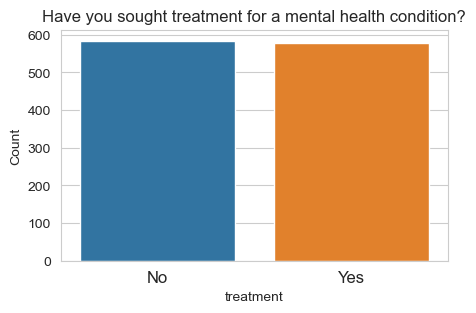

In [19]:
plt.figure(figsize=(5, 3))
sns.countplot(x=data['treatment'])
plt.title("Have you sought treatment for a mental health condition?")
plt.ylabel("Count")
plt.xticks(fontsize=12)
plt.show()

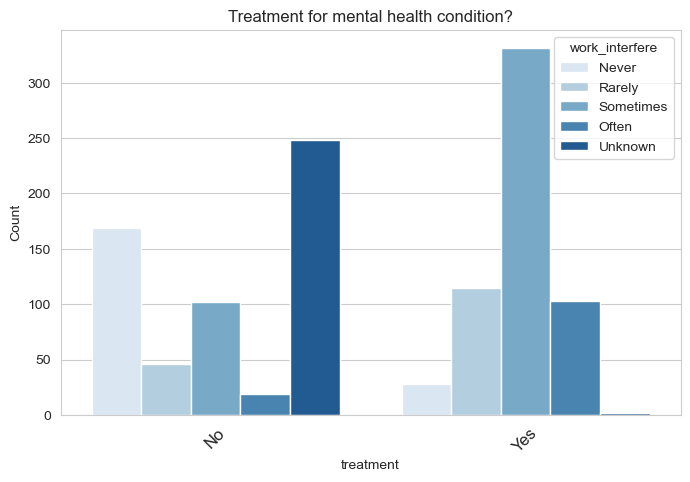

In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(x=data['treatment'],
              hue=data['work_interfere'],
              hue_order=['Never', 'Rarely', 'Sometimes', 'Often', 'Unknown'],
              palette='Blues')
plt.title("Treatment for mental health condition?")
plt.ylabel("Count")
plt.xticks(fontsize=12, rotation=45)
plt.savefig(os.path.join('images', 'treatment-work-plot.png'))
plt.show()

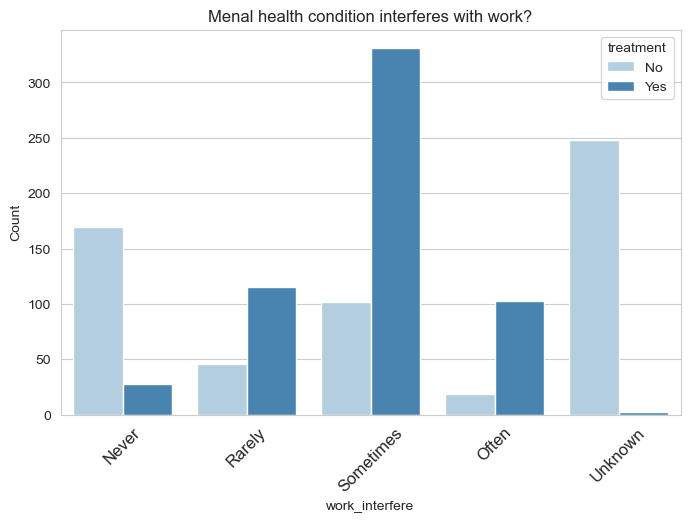

In [21]:
plt.figure(figsize=(8, 5))
sns.countplot(x=data['work_interfere'],
              hue=data['treatment'],
              hue_order=['No', 'Yes'],
              order=['Never', 'Rarely', 'Sometimes', 'Often', 'Unknown'],
              palette='Blues')
plt.title("Menal health condition interferes with work?")
plt.ylabel("Count")
plt.xticks(fontsize=12, rotation=45)
plt.savefig(os.path.join('images', 'work-treatment.png'))
plt.show()

## Workplace features statistics


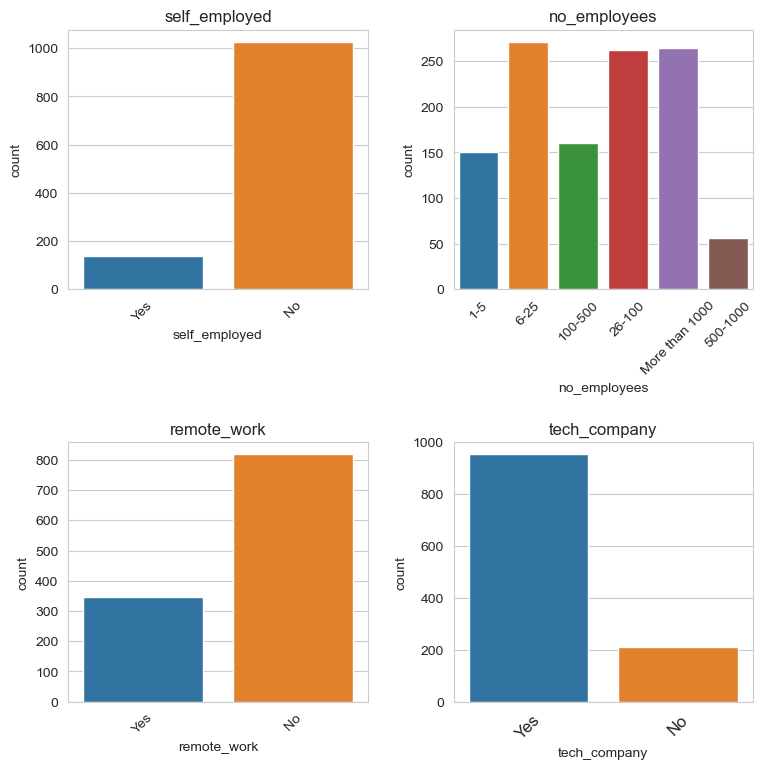

In [22]:
get_basic_stats(['self_employed', 'no_employees', 'remote_work', 'tech_company'], data, 'workplace-environment.png')

## Care options basic statistics

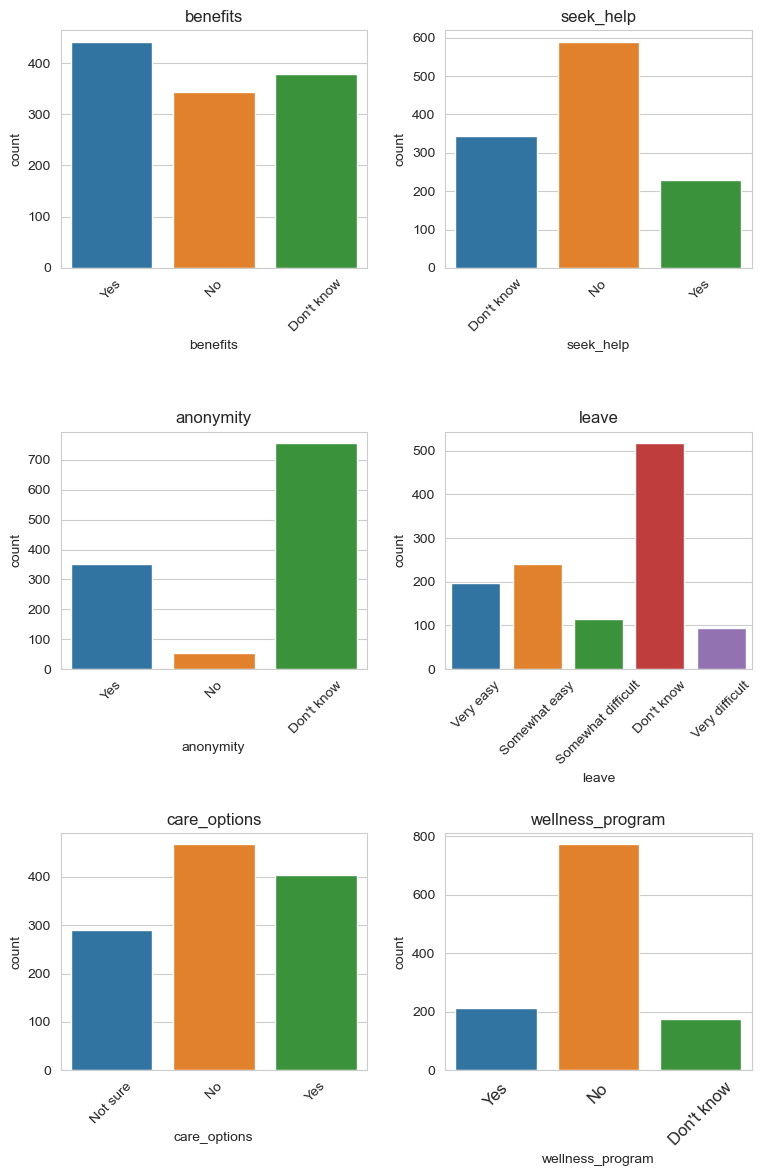

In [23]:
get_basic_stats(['benefits', 'seek_help', 'anonymity', 'leave', 'care_options', 'wellness_program'], data, 'care-options.png')

## Attitude basic statistics

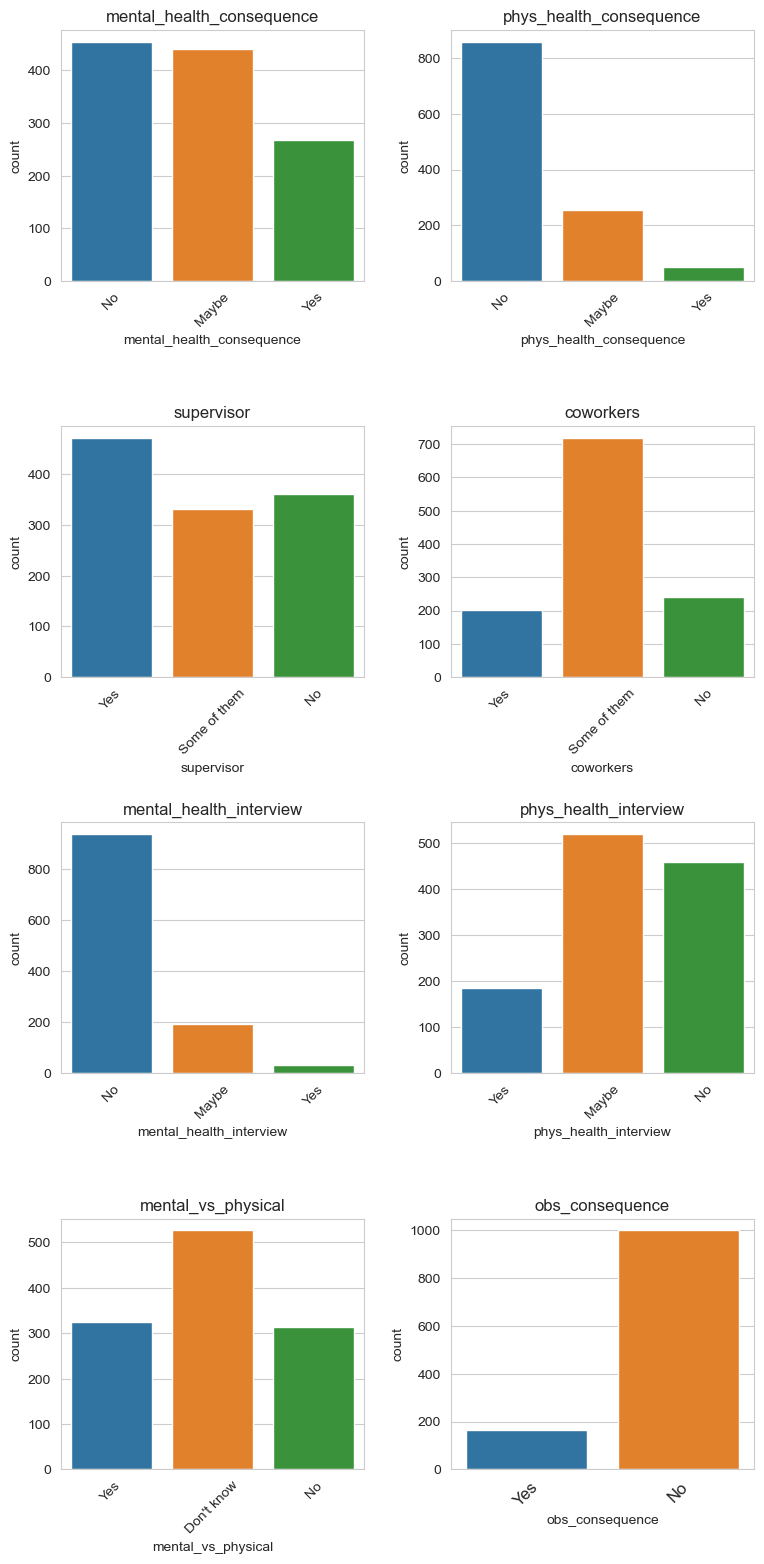

In [24]:
get_basic_stats(['mental_health_consequence', 'phys_health_consequence', 'supervisor', 'coworkers', 
                 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence'], data, 'attitude.png')

## Encoding: categorical values -> numeric values

1. Scale:
    * work_interfere: 5 levels (Unknown: 0 --- Often: 3)
    * no_employees: 6 levels (1-5: 0 --- More than 1000:5)
    * leave: 5 levels (very easy: 0 -- Very difficult: 4)


2. Binary (Yes: 1 --- No: 0): 
    * self_employed
    * family_history
    * treatment
    * remote_work
    * tech_company
    * obs_consequence

3. Questions with 'don't know', 'Some of them', 'Not sure', 'Maybe' answer (No: 0, Don't know/Some of them/Not sure/ Maybe: 0.5, Yes: 1):
    * benefits
    * care_options
    * wellnuess_program 
    * seek_help
    * anonymity
    * mental_vs_physical
    * coworkers
    * supervisor
    * mental_health_consequence
    * phys_health_consequence
    * mental_health_interview
    * phys_health_interview

4. Gender: one-hot encoding

In [25]:
not_encoded_data = data.copy()

encoded_data = data.copy()

encoded_data['work_interfere'] = encoded_data['work_interfere'].map({'Unknown': 0, 'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3})
encoded_data['no_employees'] = encoded_data['no_employees'].map({'1-5': 0, '6-25': 1, '26-100': 2, '100-500': 3, '500-1000': 4, 'More than 1000': 5})
encoded_data['leave'] = encoded_data['leave'].map({'Very easy': 0, 'Somewhat easy': 1, "Don't know": 2, 'Somewhat difficult': 3, 'Very difficult': 4})

all_columns = encoded_data.columns.tolist()
columns_to_exclude = ['work_interfere', 'no_employees', 'leave']
remaining_columns = [col for col in all_columns if col not in columns_to_exclude]

mapping = {
    'Yes': 1,
    "Don't know": 0.5,
    'Some of them': 0.5,
    'Not sure': 0.5,
    'Maybe': 0.5,
    'No': 0
}
for col in remaining_columns:
    encoded_data[col].replace(mapping, inplace=True)

encoded_gender = pd.get_dummies(encoded_data['gender'], prefix='gender')
encoded_data = pd.concat([encoded_data, encoded_gender], axis=1)

# Dropping the original gender column
encoded_data.drop(['gender'], axis=1, inplace=True)


# normalizing values
data_values = encoded_data.values
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_values)
normalized_data = pd.DataFrame(normalized_data, columns=encoded_data.columns)

normalized_data.head()
normalized_data.columns

Index(['age', 'self_employed', 'family_history', 'treatment', 'work_interfere',
       'no_employees', 'remote_work', 'tech_company', 'benefits',
       'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'gender_female', 'gender_male',
       'gender_other'],
      dtype='object')

In [26]:
print(f'Number of entries in raw data: {len(data_raw)}')
print(f'Number of entries after preprocessing: {len(normalized_data)}')
print(f'Number of columns in raw data: {len(data_raw.columns)}')
print(f'Number of columns after preprocessing: {len(normalized_data.columns)}')

Number of entries in raw data: 1259
Number of entries after preprocessing: 1163
Number of columns in raw data: 27
Number of columns after preprocessing: 25


## Dataset for experiments

In [27]:
data = normalized_data.copy()

X = data.drop(['treatment', 'work_interfere'], axis=1)
y1 = data['work_interfere']
y2 = data['treatment']
y3 = data['treatment'] * data['work_interfere']

random_state = 13

## Correlation matrix

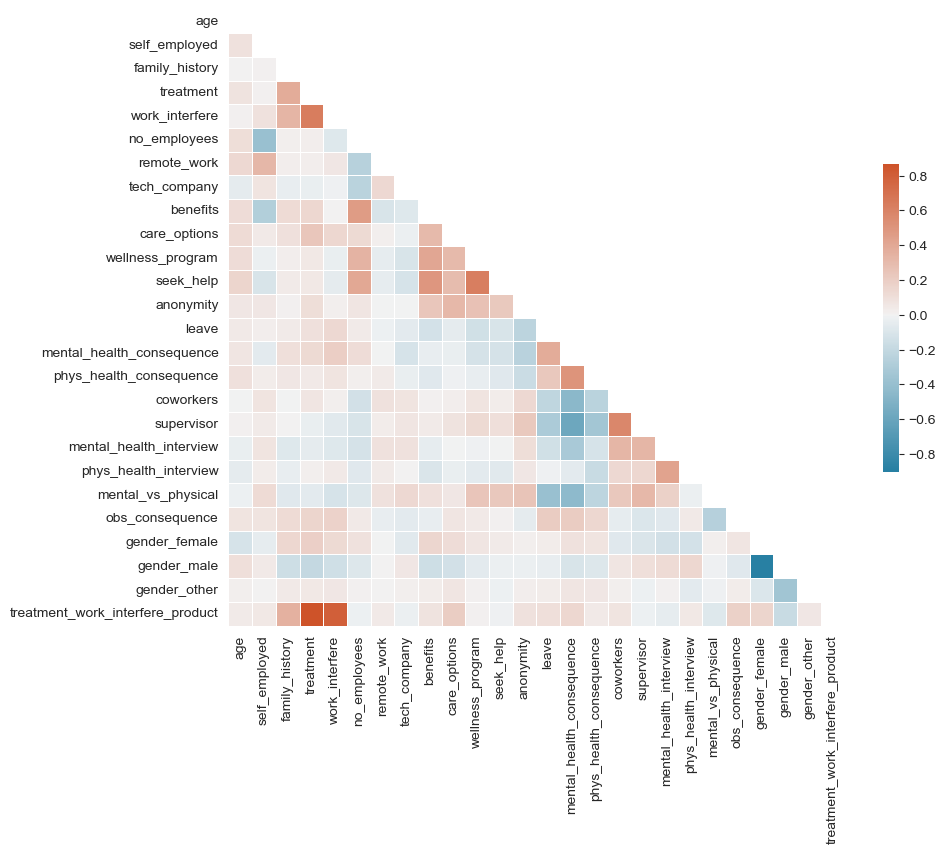

In [28]:
data = normalized_data.copy()
data['treatment_work_interfere_product'] = data['treatment'] * data['work_interfere']
corr = data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20,  s=90, l=50, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig(os.path.join('images', 'corr-matrix.png'))

In [29]:
corr_pairs = corr.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs != 1]
corr_pairs = corr_pairs[corr_pairs.index.map(lambda x: x[0] < x[1])]

print('Top positive correlations:')
print(corr_pairs.head(10))


corr_pairs = corr.unstack().sort_values(ascending=True)
corr_pairs = corr_pairs[corr_pairs != 1]
corr_pairs = corr_pairs[corr_pairs.index.map(lambda x: x[0] < x[1])]

print('Top negative correlations:')
print(corr_pairs.head(10))

Top positive correlations:
treatment                         treatment_work_interfere_product    0.869830
treatment_work_interfere_product  work_interfere                      0.796654
treatment                         work_interfere                      0.632962
seek_help                         wellness_program                    0.624695
coworkers                         supervisor                          0.574209
mental_health_consequence         phys_health_consequence             0.506437
benefits                          seek_help                           0.490903
                                  no_employees                        0.466844
mental_health_interview           phys_health_interview               0.433197
benefits                          wellness_program                    0.406576
dtype: float64
Top negative correlations:
gender_female              gender_male                 -0.900728
mental_health_consequence  supervisor                  -0.582648
coworkers  

In [30]:
def get_most_important_fetaures(columns, importance, n=5, show=True):
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)
    feature_importance_df = feature_importance_df.head(n)
    return feature_importance_df

Feature importance: correlation matrix

In [31]:
print('\nMost important features for work_interfere:')
print(get_most_important_fetaures(data.columns, corr['work_interfere'], 8).tail(5))
print('Most important features for treatment:')
print(get_most_important_fetaures(data.columns, corr['treatment'], 8).tail(5))
print('\nMost important features for treatment_work_interfere_product:')
print(get_most_important_fetaures(data.columns, corr['treatment_work_interfere_product'], 8).tail(5))


Most important features for work_interfere:
                     Feature  Importance
3             family_history    0.334235
4  mental_health_consequence    0.196258
5            obs_consequence    0.177886
6               care_options    0.144964
7                      leave    0.129800
Most important features for treatment:
           Feature  Importance
3   family_history    0.384161
4     care_options    0.235402
5    gender_female    0.185874
6  obs_consequence    0.159074
7         benefits    0.138294

Most important features for treatment_work_interfere_product:
                     Feature  Importance
3             family_history    0.356483
4               care_options    0.203670
5            obs_consequence    0.182370
6              gender_female    0.163761
7  mental_health_consequence    0.140258


## SVM Model for treatment

Accuracy of SVM model:  0.7079037800687286


,Feature,Importance
0,family_history,1.999547
1,age,0.001103
2,coworkers,0.000828
3,care_options,0.000455
4,mental_health_consequence,0.000451


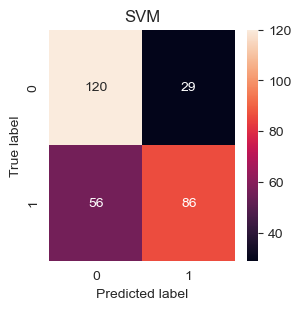

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = train_test_split(X, y2, test_size=0.25, random_state=random_state)

clf_svm = SVC(kernel='linear')
clf_svm.fit(x_train,y_train)

y_pred = clf_svm.predict(x_test)

ac = accuracy_score(y_test, y_pred)
print('Accuracy of SVM model: ', ac)

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d")
plt.title('SVM')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# get_most_important_fetaures(X.columns, clf_svm.coef_.ravel(), 5)

## PCA

Explained variance: [0.51373783 0.45604862]
Most important features for PC1: 
          Feature  Importance
0       treatment    0.480958
1  family_history    0.376527
2   gender_female    0.305439
3        benefits    0.268926
4    care_options    0.267652
Most important features for PC2: 
                     Feature  Importance
0  mental_health_consequence    0.378170
1                      leave    0.191418
2    phys_health_consequence    0.169851
3             work_interfere    0.115581
4            obs_consequence    0.114567


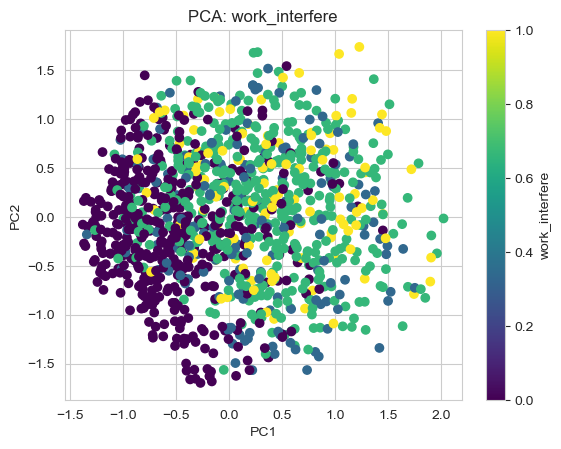

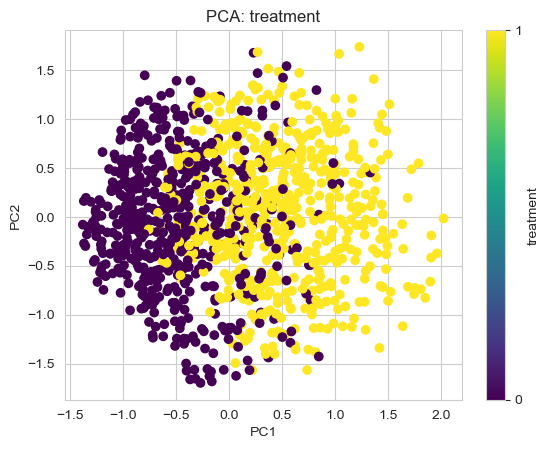

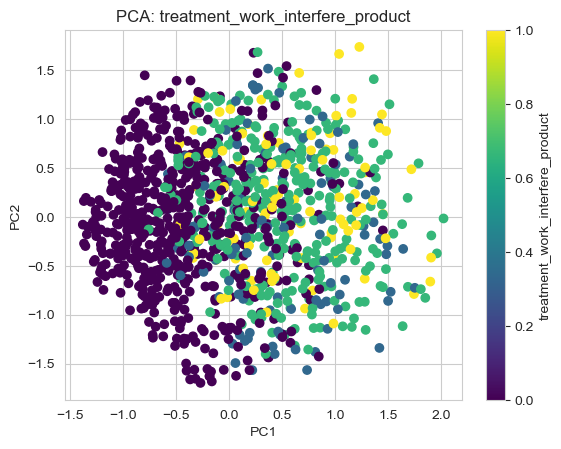

In [33]:
X = normalized_data.copy()
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

print(f'Explained variance: {pca.explained_variance_}')

print(f'Most important features for PC1: ')
print(get_most_important_fetaures(columns=X.columns, importance=pca.components_[0]))

print(f'Most important features for PC2: ')
print(get_most_important_fetaures(columns=X.columns, importance=pca.components_[1]))

plt.scatter(pca_df['PC1'], pca_df['PC2'], c=y1, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: work_interfere')
plt.colorbar(label='work_interfere')
plt.savefig(os.path.join('images', 'pca-work-interfere.png'))
plt.show()


plt.scatter(pca_df['PC1'], pca_df['PC2'], c=y2, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: treatment')
plt.colorbar(ticks=[0, 1], label='treatment')
plt.savefig(os.path.join('images', 'pca-treatment.png'))
plt.show()


plt.scatter(pca_df['PC1'], pca_df['PC2'], c=y3, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: treatment_work_interfere_product')
plt.colorbar(label='treatment_work_interfere_product')
plt.savefig(os.path.join('images', 'pca-product.png'))
plt.show()


## Linear regression: feature importance

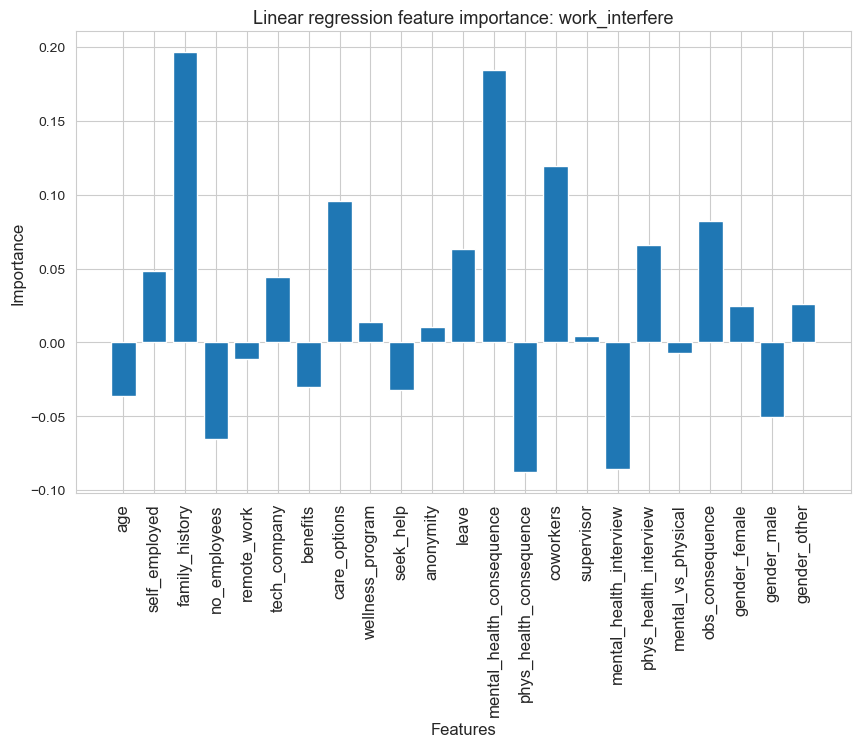

R-squared score: 0.1961795217360064
Feature importance: 
                     Feature  Importance
0             family_history    0.196378
1  mental_health_consequence    0.184187
2                  coworkers    0.119771
3               care_options    0.096014
4            obs_consequence    0.082123


In [34]:
X = X.drop(['treatment', 'work_interfere'], axis=1)
y = y1
model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

importance = model.coef_

plt.figure(figsize=(10, 6))
plt.bar(X.columns, importance)
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Linear regression feature importance: work_interfere', fontsize=13)
plt.savefig(os.path.join('images', 'regression-work-interfere.png'))
plt.show()


r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

print('Feature importance: ')
print(get_most_important_fetaures(X.columns, importance))

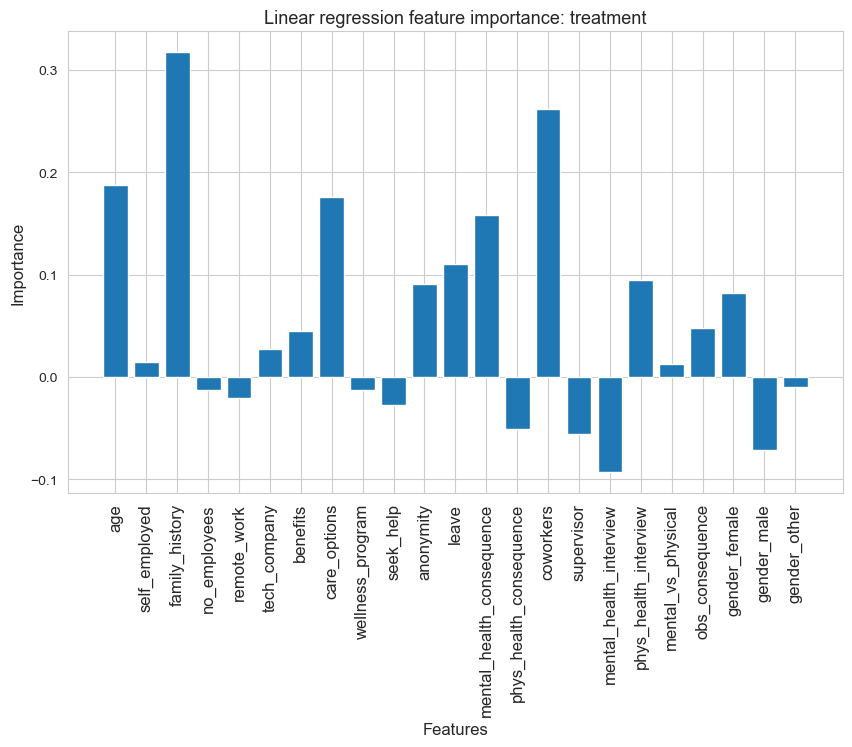

R-squared score: 0.16670596803757243
Feature importance: 
                     Feature  Importance
0             family_history    0.317033
1                  coworkers    0.261513
2                        age    0.187350
3               care_options    0.176175
4  mental_health_consequence    0.157789


In [35]:
y = y2
model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
model.fit(X_train, y_train)

importance = model.coef_

plt.figure(figsize=(10, 6))
plt.bar(X.columns, importance)
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Linear regression feature importance: treatment', fontsize=13)
plt.savefig(os.path.join('images', 'regression-treatment.png'))
plt.show()


r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

print('Feature importance: ')
print(get_most_important_fetaures(X.columns, importance))

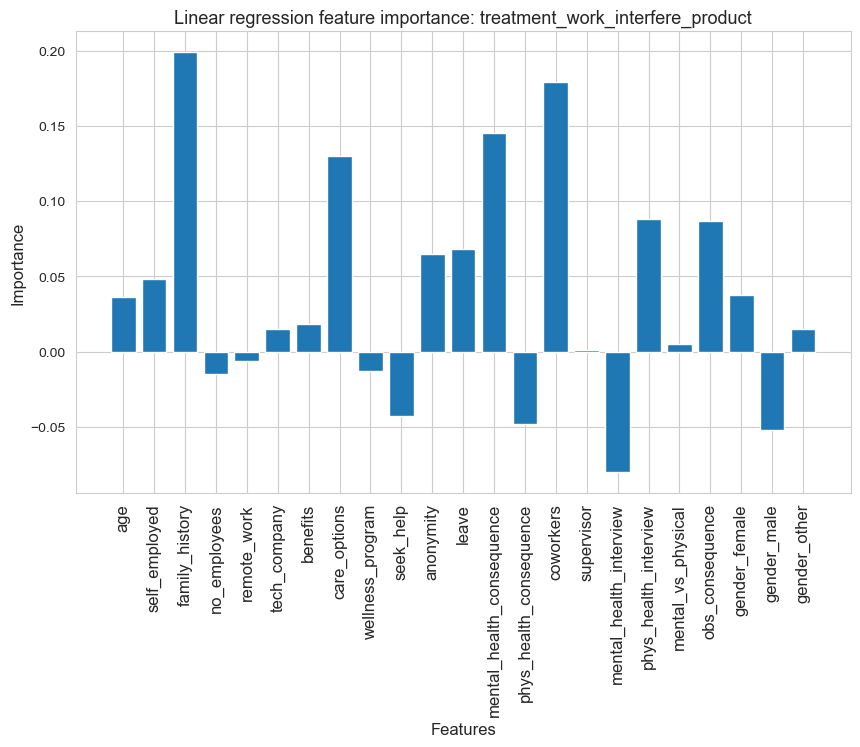

R-squared score: 0.15178530861513928
Feature importance: 
                     Feature  Importance
0             family_history    0.198745
1                  coworkers    0.178905
2  mental_health_consequence    0.145107
3               care_options    0.129910
4      phys_health_interview    0.088318


In [36]:
y = y3
model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
model.fit(X_train, y_train)

importance = model.coef_

plt.figure(figsize=(10, 6))
plt.bar(X.columns, importance)
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Linear regression feature importance: treatment_work_interfere_product', fontsize=13)
plt.savefig(os.path.join('images', 'regression-product.png'))
plt.show()

r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

print('Feature importance: ')
print(get_most_important_fetaures(X.columns, importance))